In [55]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

import keras
from keras.layers import Dense, Activation, Convolution2D, Reshape, Flatten, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D, Input, Dropout
from keras.models import Sequential, Model

In [41]:
ds = pd.read_csv('./train.csv')
data = ds.values[:10000]

In [42]:
print data.shape
X = data[:, 1:]/255.0
X = X.reshape((X.shape[0], 28, 28, 1))

split = int(0.65 * X.shape[0])
X_train = X[:split]
X_val = X[split:]

print X_train.shape, X_val.shape

(10000, 785)
(6500, 28, 28, 1) (3500, 28, 28, 1)


In [79]:
# Autoencoder
embedding_shape = 32

inp = Input(shape=(28, 28, 1))

#--------- Encoder ------------------#
c1 = Convolution2D(32, 3, 3, activation='relu')(inp)
c2 = Convolution2D(16, 3, 3, activation='relu')(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(c2)
c3 = Convolution2D(8, 3, 3, activation='relu')(m1)

#---------- Embedding ----------------#
f1 = Flatten()(c3)
f1 = Dropout(0.4)(f1)

fc1 = Dense(embedding_shape, activation='sigmoid')(f1)
fc2 = Dense(800, activation='relu')(fc1)

rs = Reshape((10, 10, 8))(fc2)

#--------- Decoder -------------------#
zp1 = ZeroPadding2D(padding=(1, 1))(rs)
dc1 = Convolution2D(16, 3, 3, border_mode='same', activation='relu')(zp1)
up1 = UpSampling2D(size=(2, 2))(dc1)

zp2 = ZeroPadding2D(padding=(1, 1))(up1)
dc2 = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(zp2)

zp3 = ZeroPadding2D(padding=(1, 1))(dc2)
dc3 = Convolution2D(1, 3, 3, border_mode='same', activation='relu')(zp3)

out = dc3

model = Model(input=inp, output=out)
model.summary()
encoder = Model(input=inp, output=fc1)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_20 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_64 (Convolution2D) (None, 26, 26, 32)    320         input_20[0][0]                   
____________________________________________________________________________________________________
convolution2d_65 (Convolution2D) (None, 24, 24, 16)    4624        convolution2d_64[0][0]           
____________________________________________________________________________________________________
maxpooling2d_12 (MaxPooling2D)   (None, 12, 12, 16)    0           convolution2d_65[0][0]           
___________________________________________________________________________________________

In [80]:
dec_in = Input(shape=(embedding_shape,))

x = model.layers[8](dec_in)

for ix in range(9, len(model.layers)):
    x = model.layers[ix](x)

decoder = Model(input=dec_in, output=x)
# decoder.summary()

In [81]:
hist = model.fit(X_train, X_train,
                nb_epoch=20,
                shuffle=True,
                batch_size=100,
                validation_data=(X_val, X_val), verbose=2)

Train on 6500 samples, validate on 3500 samples
Epoch 1/20
2s - loss: 0.0695 - acc: 0.7998 - val_loss: 0.0552 - val_acc: 0.7939
Epoch 2/20
2s - loss: 0.0426 - acc: 0.8018 - val_loss: 0.0316 - val_acc: 0.8066
Epoch 3/20
2s - loss: 0.0294 - acc: 0.8065 - val_loss: 0.0237 - val_acc: 0.8093
Epoch 4/20
2s - loss: 0.0238 - acc: 0.8085 - val_loss: 0.0193 - val_acc: 0.8099
Epoch 5/20
2s - loss: 0.0207 - acc: 0.8096 - val_loss: 0.0170 - val_acc: 0.8102
Epoch 6/20
2s - loss: 0.0190 - acc: 0.8101 - val_loss: 0.0155 - val_acc: 0.8111
Epoch 7/20
2s - loss: 0.0178 - acc: 0.8106 - val_loss: 0.0145 - val_acc: 0.8113
Epoch 8/20
2s - loss: 0.0166 - acc: 0.8110 - val_loss: 0.0137 - val_acc: 0.8115
Epoch 9/20
2s - loss: 0.0159 - acc: 0.8113 - val_loss: 0.0128 - val_acc: 0.8117
Epoch 10/20
2s - loss: 0.0153 - acc: 0.8114 - val_loss: 0.0124 - val_acc: 0.8118
Epoch 11/20
2s - loss: 0.0147 - acc: 0.8117 - val_loss: 0.0121 - val_acc: 0.8118
Epoch 12/20
2s - loss: 0.0143 - acc: 0.8117 - val_loss: 0.0114 - val_a

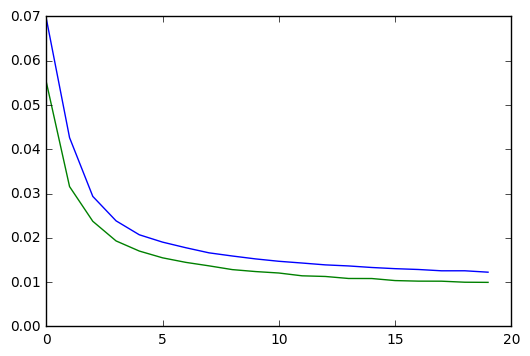

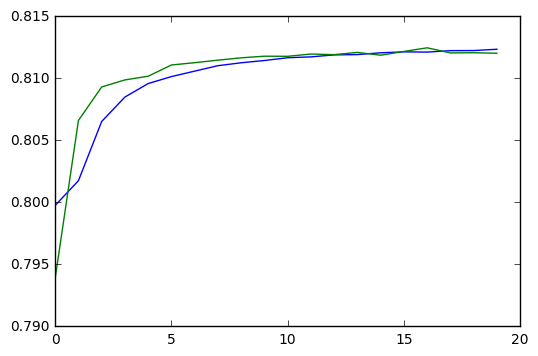

In [82]:
th = hist.history

plt.figure(0)
plt.plot(th['loss'], 'b')
plt.plot(th['val_loss'], 'g')

plt.figure(1)
plt.plot(th['acc'], 'b')
plt.plot(th['val_acc'], 'g')

In [83]:
emb = encoder.predict(X_train[:1000])
print emb.shape

(1000, 32)


In [84]:
new_emb = np.random.sample((10, embedding_shape))
print new_emb.shape

(10, 32)


In [85]:
out = decoder.predict(new_emb)
print out.shape

(10, 28, 28, 1)


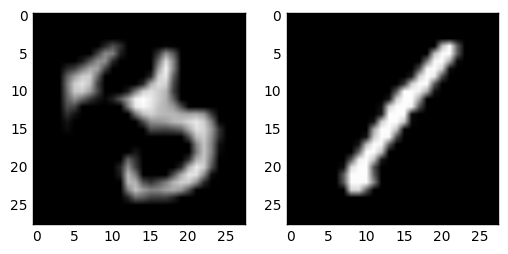

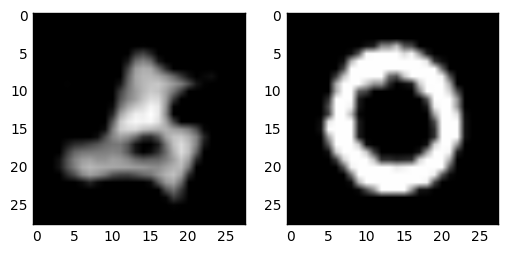

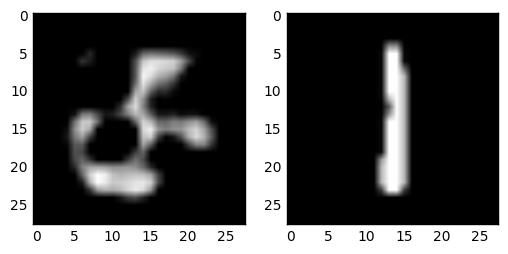

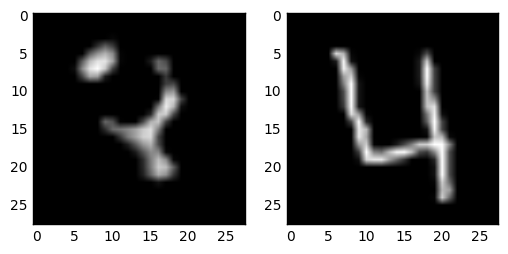

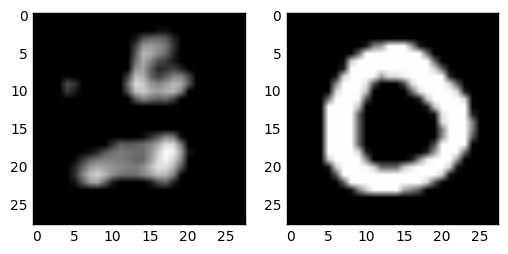

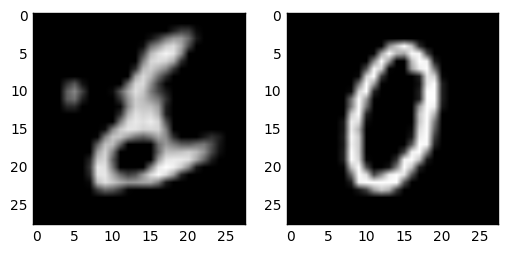

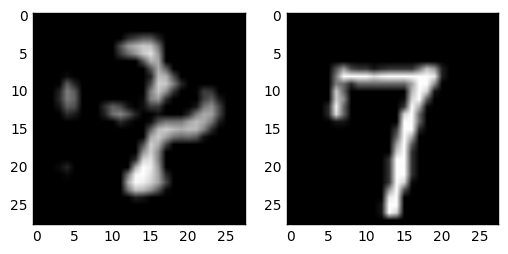

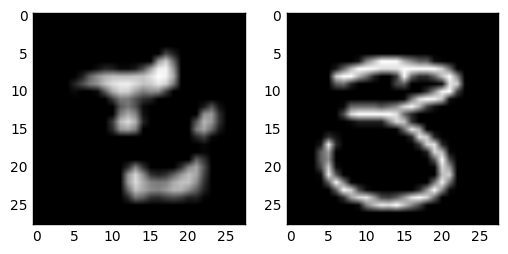

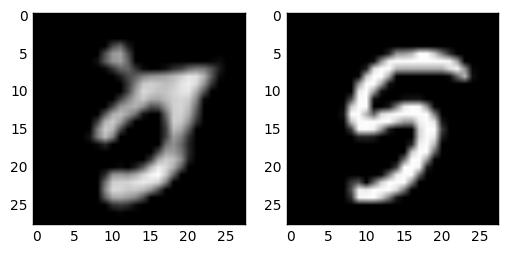

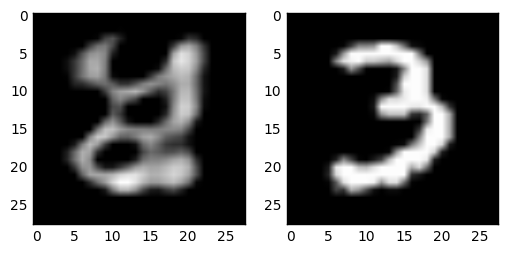

In [86]:
for ix in range(10):
    plt.figure(ix)
    plt.subplot(1, 2, 1)
    plt.imshow(out[ix].reshape((28, 28)), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(X_train[ix].reshape((28, 28)), cmap='gray')
plt.show()